In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import scipy.stats as stats

#visualization
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
# Library for Statistics
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import f_oneway

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder,RobustScaler,StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import average_precision_score

# Library for Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor

# Library for ML Algorithm
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA

# Library for Evaluation
from sklearn.model_selection import cross_validate, LearningCurveDisplay
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score

import xgboost as xgb
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Context

An investment bank is aiming to optimize its investment strategy by identifying stocks that will have the lowest opening prices in the future. To achieve this goal, I, as a data scientist, have been tasked with developing a predictive model that accurately forecasts the opening prices of stocks. This model will leverage historical stock data, including various time-based features such as the day of the year, hour, day of the week, quarter, month, and year, as well as lagged values of past opening prices to capture trends and patterns over time. By employing advanced machine learning algorithms, such as XGBoost or other regression-based models, the model will be trained to predict future opening prices based on these features. The ultimate objective is to provide the bank with actionable insights, enabling them to make informed decisions about which stocks to invest in by focusing on those predicted to have the lowest opening prices, thereby potentially maximizing their return on investment. The success of this project hinges on the model's accuracy in forecasting and its ability to generalize well to unseen data, ensuring that the investment bank can confidently rely on the predictions to guide their future investment strategies.

In [3]:
data = pd.read_csv(r'D:\Coding Projects\ArtikelTask3\2024stockdataDateAndOpenPrice.csv')
df = data.copy()
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

In [4]:
df = df.drop(columns='Unnamed: 0')
display(df.head(), df.tail())

,Open
Date,
2024-01-02,90.819397
2024-01-03,91.329430
2024-01-04,90.367889
2024-01-05,90.284279
2024-01-08,90.518394


,Open
Date,
2024-08-26,181.039993
2024-08-27,181.979996
2024-08-28,182.100006
2024-08-29,183.910004
2024-08-30,183.089996


In [5]:
colAndRows= pd.DataFrame(df.shape, index=['rows', 'columns'], columns=['count'])
print('The count of columns and rows in this dataframe: ')
colAndRows

The count of columns and rows in this dataframe: 


,count
rows,84254
columns,1


In [6]:
df.describe()

,Open
count,84254.000000
mean,205.755014
std,436.412282
min,6.670000
25%,62.790001
50%,118.844997
75%,222.304996
max,9325.000000


The summary statistics provided for the 'Open' price in the dataset reveal several key insights about the distribution of the data. There are 84,254 observations in total, with an average (mean) 'Open' price of approximately 205.76. However, the data exhibits substantial variability, as indicated by the standard deviation of about 436.41, which is quite large relative to the mean. This high standard deviation suggests that the 'Open' prices are widely dispersed around the mean, indicating a high degree of volatility in the dataset.

The minimum 'Open' price recorded is 6.67, while the maximum is 9,325, demonstrating an extremely wide range of values. The 25th percentile (62.79), 50th percentile (118.84), and 75th percentile (222.30) indicate that a significant portion of the data is clustered toward the lower end of the range, with the median (50th percentile) being much lower than the mean. This skewness suggests that while most values are relatively low, a small number of very high 'Open' prices are pulling the mean upwards.

Overall, this distribution highlights a dataset with substantial variability and a strong right skew, where the majority of 'Open' prices are on the lower end, but a few exceptionally high values exist. This kind of distribution can pose challenges in modeling, as the model needs to capture both the frequent lower values and the rare but extreme high values effectively.

In [7]:
pd.DataFrame(
    {'Name': df.columns,
     'Type': df.dtypes,
     'NaN' : df.isna().sum(),
     'NaN (%)': df.isna().mean() * 100,
     'Unique' : [df[col].nunique() for col in df.columns],
     'Sample': [df[col].unique() for col in df.columns]}
)

,Name,Type,NaN,NaN (%),Unique,Sample
Open,Open,float64,0,0.0,35466,"[90.81939697265624, 91.32942962646484, 90.3678..."


In [8]:
print(f'The data contains {df.duplicated().sum()} duplicated values')

The data contains 48788 duplicated values


# Exploratory Data Analysis

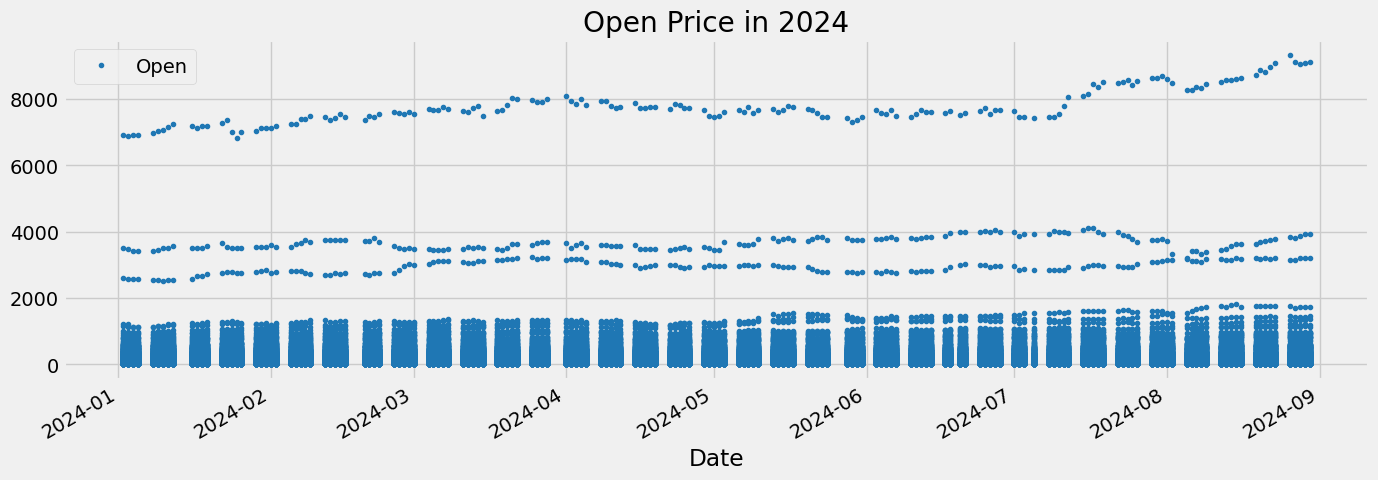

In [9]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Open Price in 2024')
plt.show()

The chart displays the opening prices of stocks throughout the year 2024. The data is plotted on a scatter plot, where each dot represents the opening price of a stock on a specific date. The chart reveals several distinct horizontal bands, indicating that the opening prices are clustered into different ranges throughout the year.

- **Clustered Price Levels**: The most notable feature of this chart is the presence of multiple price bands. This suggests that there are distinct groups of stocks with opening prices that are consistently within certain ranges. For example, one cluster appears around the lower end near 0-2000, another around 2000-4000, and a higher one above 6000. These bands could represent different categories of stocks (e.g., small-cap vs. large-cap) or stocks from different sectors that tend to have similar pricing.

- **Stability Over Time**: The horizontal nature of the bands indicates that within these price clusters, the opening prices remain relatively stable over time, with only minor fluctuations. This could suggest that the market is relatively calm and that the stocks in these clusters do not experience extreme volatility in their opening prices.

- **Seasonal or Trend-Related Fluctuations**: Towards the later part of the year, particularly from July onwards, there seems to be a slight upward trend in some of the clusters, particularly the higher-priced stocks. This might indicate a seasonal trend or some market conditions causing a gradual increase in the opening prices of certain stocks.

- **Outliers or Variability**: The chart shows a few points that deviate slightly from the main clusters, which could represent outliers or stocks that are experiencing more significant changes in their opening prices compared to others.

Overall, this chart suggests that the market in 2024 is characterized by distinct groups of stocks with relatively stable opening prices within each group. The observed slight upward trend later in the year for some stocks might be worth further investigation to understand the underlying factors driving these changes.

# Modeling

## Feature Creation

In [10]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [12]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

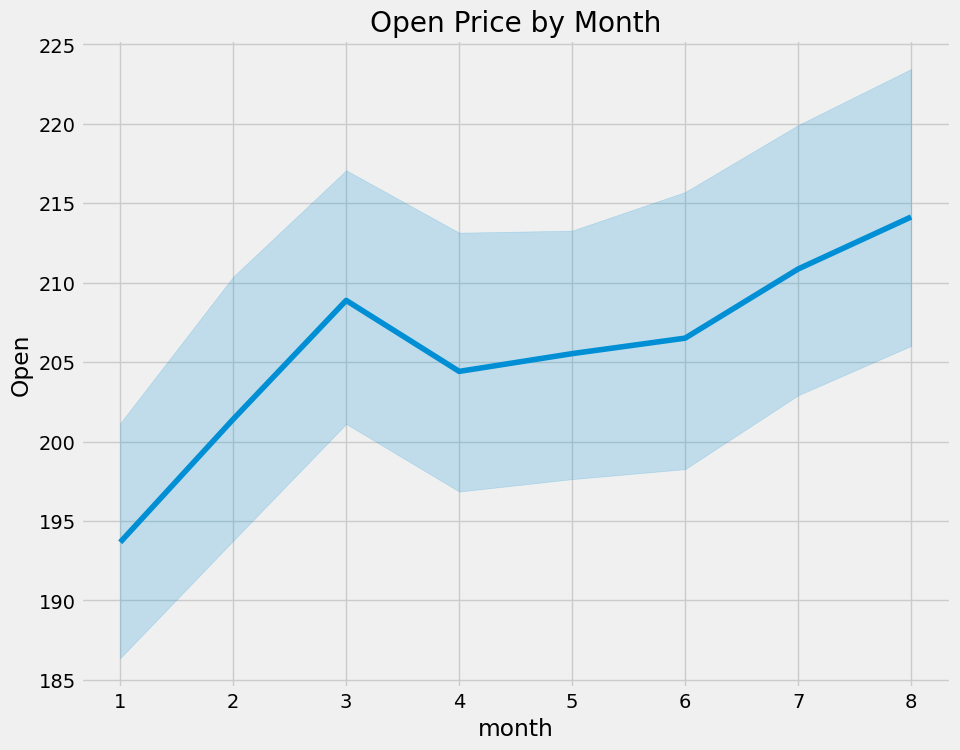

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x='month', y='Open')
ax.set_title('Open Price by Month')
plt.show()

### Insights:

- **Seasonal Trend**: The chart indicates a clear seasonal pattern in the opening prices across the months. The average opening price starts at a lower level in January (around 195) and increases steadily until March, where it peaks at around 210. After March, there is a slight decline in April, followed by a gradual increase from May onwards, with the average opening price reaching around 215 by August.

- **Variability**: The shaded area around the line represents the variability or confidence interval in the opening prices. This area is widest in March, indicating higher uncertainty or variability in the opening prices during this month. The variability decreases slightly after March but then begins to widen again towards August, suggesting that the prices are less predictable or more volatile during these months.

- **Implications**: The observed trend suggests that certain months, particularly March and August, experience either higher volatility or differing market conditions that lead to fluctuations in opening prices. For investors, this information could be useful for timing investments or understanding when to expect more stable versus volatile market conditions.

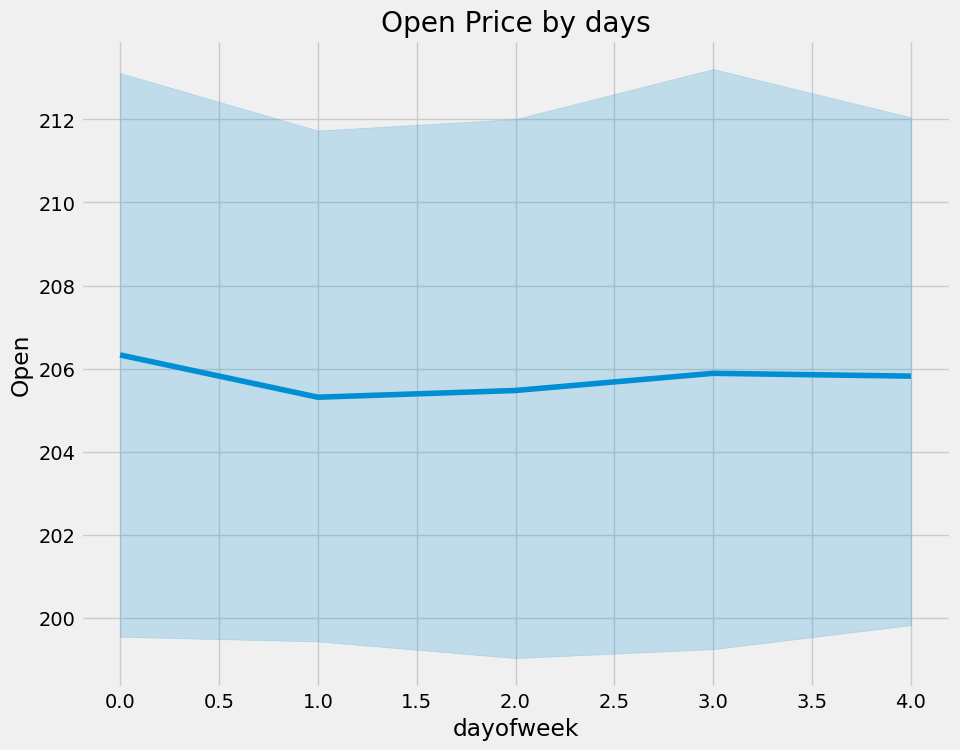

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df, x='dayofweek', y='Open')
ax.set_title('Open Price by days')
plt.show()

### Insights:

- **Weekly Pattern**: The chart reveals a subtle downward trend in the average opening price as the week progresses, with the lowest average occurring mid-week, around Tuesday or Wednesday (day 1.0-2.0). This is followed by a slight increase towards the end of the week, although the average prices remain relatively stable throughout.

- **Variability**: The shaded region, which represents the variability in opening prices, is relatively consistent across the days of the week but shows a slightly wider range at the beginning and end of the week. This suggests that while the average prices are stable, there is a bit more uncertainty or variability in the prices on Mondays and Fridays compared to the middle of the week.

- **Implications**: The consistent opening prices across the week indicate a stable market environment without significant day-to-day fluctuations. The slight dip in the middle of the week could be influenced by various market factors, such as the resolution of events from the previous week or early week trading momentum. The slightly higher variability at the start and end of the week might reflect market adjustments or reactions to news and events that typically occur over the weekend or towards the week's close.

In [15]:
from statsmodels.tsa.stattools import adfuller

# Define a function to perform the Dickey-Fuller test
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(df['Open'])

ADF Statistic: -17.408560
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


In [16]:
df_seen = df.loc[df.index < '2024-06-01']
df_unseen = df.loc[df.index >= '2024-06-01']

In [17]:
X = df_seen[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']]
y = df_seen[['Open']]


# Split data into training and test sets
# Typically, X_train and y_train should come from df_seen, while X_test and y_test should come from df_unseen
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_val = train_test_split(y, test_size=0.2, random_state=42)

In [18]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train,verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# Making predictions on the unseen dataset
X_unseen = df_unseen[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']]
df_unseen['prediction'] = reg.predict(X_unseen)

# Now df_unseen contains the predictions for unseen data
df_unseen

,Open,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Date,,,,,,,,,,
2024-06-03,100.370003,0,0,2,6,2024,155,3,23,196.431946
2024-06-04,99.000000,0,1,2,6,2024,156,4,23,196.909622
2024-06-05,98.820000,0,2,2,6,2024,157,5,23,196.708145
2024-06-06,98.800003,0,3,2,6,2024,158,6,23,197.091049
2024-06-07,99.510002,0,4,2,6,2024,159,7,23,196.852081
...,...,...,...,...,...,...,...,...,...,...
2024-08-26,181.039993,0,0,3,8,2024,239,26,35,196.431946
2024-08-27,181.979996,0,1,3,8,2024,240,27,35,196.909622
2024-08-28,182.100006,0,2,3,8,2024,241,28,35,196.708145


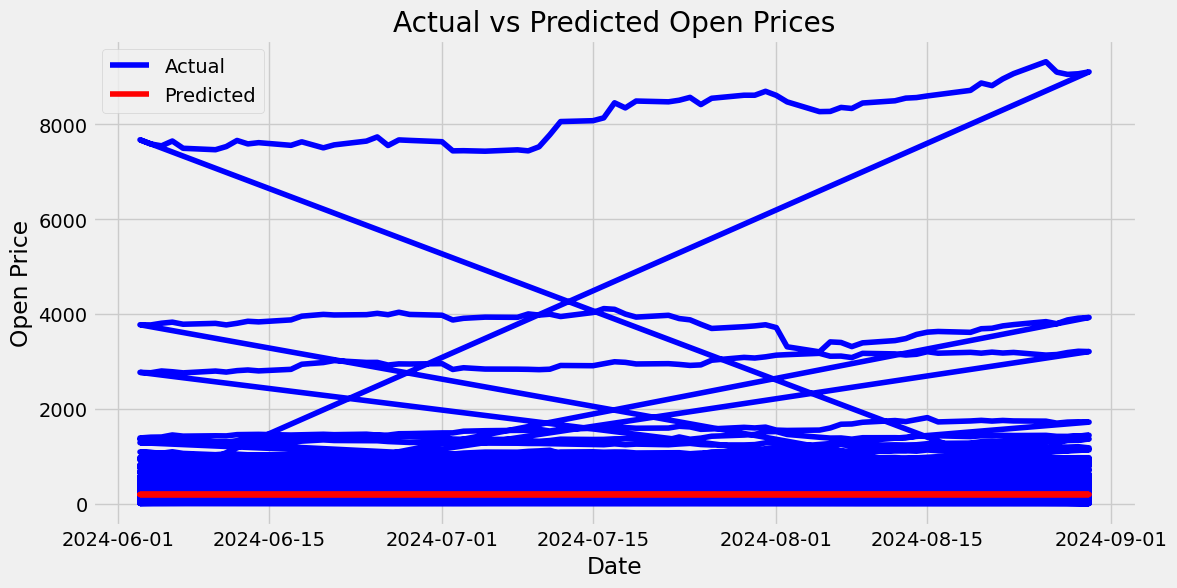

In [33]:
plt.figure(figsize=(12, 6))

# Plot the actual values
plt.plot(df_unseen.index, df_unseen['Open'], label='Actual', color='blue')

# Plot the predicted values
plt.plot(df_unseen.index, df_unseen['prediction'], label='Predicted', color='red')

# Adding title and labels
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()

# Show the plot
plt.show()

### Insights:

- **Significant Discrepancy**: The chart reveals a significant discrepancy between the actual and predicted values. The actual opening prices vary widely, with some stocks reaching prices as high as 8000, while others are much lower. In contrast, the predicted prices are almost a flat line near zero, indicating that the model has consistently predicted very low opening prices, regardless of the actual values.

- **Model Performance**: The near-flat line of the predictions suggests that the model is failing to capture the variability and trends in the actual opening prices. This could be due to several reasons, such as an inadequately trained model, incorrect feature selection, or overfitting/underfitting issues. The model might be heavily biased towards lower values, leading to inaccurate predictions for higher-priced stocks.

In [35]:
score = mean_absolute_percentage_error(df_unseen['Open'], df_unseen['prediction'])
print(f'MAPE Score on Test set: {score:0.2f}')

MAPE Score on Test set: 1.8231391644766062


Given that the MAPE score in this case is 1.82 (or 182% if expressed as a percentage), it suggests that the model's predictions are, on average, 182% away from the actual values. This level of error is unacceptably high, as it means the model's predictions are not just inaccurate but significantly so. Such a high MAPE score typically implies that the model is failing to capture the underlying patterns in the data and may be severely overfitting or underfitting.

# Conclusion and Recommendation

### Conclusion:

The model used for predicting stock open prices demonstrates significant unreliability, as evidenced by a Mean Absolute Percentage Error (MAPE) score of approximately 182%. This score, which measures the average absolute percentage difference between the predicted and actual values, is exceedingly high, suggesting that the model's predictions are far from accurate. Typically, a lower MAPE score indicates better model performance, with values under 10% generally considered good for most applications. However, a MAPE of 182% implies that the model’s predictions deviate drastically from the actual prices, often by more than the value being predicted. This high level of error indicates that the model is unable to capture the inherent patterns and variability in the data, resulting in predictions that are not just inaccurate but also consistently off target. This inadequacy is further highlighted by the flatness of the predicted values when compared to the actual open prices, as seen in the provided graph. The predicted values fail to reflect the fluctuations and trends in the actual data, suggesting that the model does not understand the dynamics of the stock prices it is attempting to forecast. This fundamental issue renders the model unreliable for practical use, as it fails to provide the actionable insights necessary for decision-making in financial contexts.

### Recommendations:

**Data Segmentation**: Consider segmenting the stock data based on specific characteristics such as price ranges, market sectors, or volatility levels before modeling. Different types of stocks may require different modeling approaches, and segmentation could improve the accuracy of predictions by allowing the model to specialize in particular segments.